In [1]:
!unzip Gd_fps.zip

Archive:  Gd_fps.zip
  inflating: Gd_ctopo_fp_ligand.csv  
  inflating: Gd_ctopo_fp_skl.csv     
  inflating: Gd_ctopo_fp_skl_da.csv  
  inflating: Gd_ctopo_fp_skl_da_bonds.csv  
  inflating: Gd_ctopo_fp_skl_da_skl.csv  
  inflating: Gd_ctopo_fp_skl_da_skl_bonds.csv  
  inflating: Gd_ctopo_fp_topo.csv    
  inflating: Gd_ctopo_fp_topo_da.csv  
  inflating: Gd_ctopo_fp_cmplx.csv   
  inflating: Gd_ctopo_fp_cmplx_da.csv  
  inflating: Gd_ctopo_fp_cmplx_da_bonds.csv  
  inflating: Gd_ctopo_fp_cmplx_da_sub.csv  
  inflating: Gd_ctopo_fp_cmplx_da_sub_bonds.csv  
  inflating: Gd_ctopo_fp_cmplx_full.csv  


In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model(model, X_test, y_test):
    """
    Evaluate a trained model on hold-out data; print metrics.
    """
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")
    return {"RMSE": rmse, "MAE": mae, "R2": r2}

In [3]:
!pip install optuna rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 56.4 MB/s eta 0:00:00


In [4]:
from sklearn.model_selection import KFold, train_test_split
import lightgbm as lgb
import numpy as np
import pandas as pd
import torch

from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors, MACCSkeys, RDKFingerprint, rdFingerprintGenerator
from rdkit.Chem.AtomPairs import Pairs, Torsions

import optuna

import shutil

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

# DISABLE WARNING FROM rdkit
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

from tqdm import tqdm
tqdm.pandas()


In [5]:

def extract_all_fingerprint(df, SMILES, morgan_radius = 2, morgan_nbits = 1024):
    from tqdm.auto import tqdm
    fps_data = []  # --> STORE NEW FEATURES DATA

    # DEFINE MORGAN GENERATOR
    #morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius = morgan_radius, fpSize = morgan_nbits, countSimulation = True, includeChirality = False)

    fcfp = rdFingerprintGenerator.GetMorganFeatureAtomInvGen()
    fcfp_gen = rdFingerprintGenerator.GetMorganGenerator(radius = morgan_nbits, fpSize = morgan_nbits, atomInvariantsGenerator = fcfp, countSimulation= True, includeChirality = False)

    atom_gen = rdFingerprintGenerator.GetAtomPairGenerator(fpSize = 2048, countSimulation= True, includeChirality = False)

    # ITERATE EVERY SAMPLE OF SMILES FEATURES
    for smiles in tqdm(df[SMILES]):
        mol = Chem.MolFromSmiles(smiles)

        if mol is None:
            print(smiles, 'is Invalid!')
            fps_data.append({})
            continue

        # STORE NEW FEATURE FOR EACH SAMPLES CREATED
        feature_rows = {}

        # # MORGAN FINGERPRINT (ECFP)
        # morgan_fp = morgan_gen.GetFingerprint(mol)
        # for i in range(morgan_nbits):
        #     feature_rows[f"Morgan_{i}"] = morgan_fp[i]

        # FUNCTIONAL-CLASS FINGERPRINT (FCFP)
        fc_fp = fcfp_gen.GetFingerprint(mol)
        for i in range(morgan_nbits):
            feature_rows[f"FCFP_{i}"] = fc_fp[i]

        # MACCS KEYS (166 BITS)
        maccs_fp = MACCSkeys.GenMACCSKeys(mol)
        for i in range(len(maccs_fp)):
            feature_rows[f"MACCS_{i}"] = int(maccs_fp[i])

        # AtomPair Fingerprint (2D)
        atompair_fp = atom_gen.GetCountFingerprint(mol)
        for i in range(morgan_nbits):
            feature_rows[f"AtomPair_{i}"] = atompair_fp[i]

        # RDKIT FINGERPRINT
        rdkit_fp = RDKFingerprint(mol)
        for i in range(len(rdkit_fp)):
            feature_rows[f"RDKIT_{i}"] = int(rdkit_fp[i])


        fps_data.append(feature_rows)

    #print(f'There are {morgan_nbits} Morgan Fingerprint Features')
    print(f'There are {len(maccs_fp)} MACCS Keys Features')
    print(f'There are {len(rdkit_fp)} RDKIT Fingerprint Features')

    # MERGE REAL DATA WITH EXTRACTED FEATURES
    fps_df = pd.DataFrame(fps_data)
    df_result = pd.concat((df, fps_df), axis = 1)

    return df_result

def extract_all_descriptors(df, SMILES):

    # GET ALL DESCRIPTORS
    descriptor_list = Descriptors._descList    # --> THESE WILL RETURN LIST OF TUPLE
    descriptors = [desc[0] for desc in descriptor_list]

    print(f'There Are {len(descriptor_list)} Descriptor Features')

    # EXTRACT ALL DESCRIPTORS FROM SMILES FEATURES
    result = []
    for smi in df[SMILES]:

        mol = Chem.MolFromSmiles(smi)

        # IF MOLECOLE IS INVALID
        if mol is None:
            row = {name : None for name, func in descriptor_list}
        else:
            # CREATE DESCRIPTORS FEATURES
            row = {name: func(mol) for name, func in descriptor_list}

        result.append(row)

    # MERGE DATA WITH EXTRACTED FEATURES
    df_descriptor = pd.DataFrame(result)
    df_result = pd.concat((df, df_descriptor), axis = 1)

    return df_result

def generate_features(path2df, random_state=42, test_size=0.2):
  data = pd.read_csv('Gd_reprs_v1.csv')
  train_df = pd.read_csv(path2df)

  print('merging data....')
  df = pd.merge(train_df, data, left_index=True, right_index=True).rename(columns={'lgK_x': 'lgK'})
  columns = [col for col in df.columns if 'bit' in col]
  df = df[columns + ['smiles', 'lgK']]
  print('merging data - done')

  print('extracting fp....')
  df = extract_all_fingerprint(df, 'smiles')
  print('extracting fp - done')
  print('extracting descriptors....')
  df = extract_all_descriptors(df, 'smiles')
  print('extracting descriptors - done')

  df = df.dropna().reset_index(drop = True)

  y = df['lgK']
  x = df.drop(labels = ['smiles', 'lgK'], axis = 1)

  x['HBond_Product'] = x['NumHDonors'] * x['NumHAcceptors']
  x['HBond_Sum'] = x['NumHDonors'] + x['NumHAcceptors']
  x['LogP_div_TPSA'] = x['MolLogP'] / (x['TPSA'] + 1)
  x['LogP_x_TPSA'] = x['MolLogP'] * x['TPSA']
  x['Flexibility_Score'] = x['NumRotatableBonds'] / (x['MolWt'] + 1)
  x['MolWt_x_AromaticRings'] = x['MolWt'] * x['NumAromaticRings']
  x['Complexity_per_MW'] = x['BertzCT'] / (x['MolWt'] + 1)
  x['Rigidity_Score'] = x['NumAromaticRings'] / (x['NumRotatableBonds'] + 1)

  return train_test_split(x, y, test_size=test_size, random_state=random_state)



In [30]:
def objective(trial, x,y):


    lgb_params = {
        'n_estimators' : trial.suggest_int("n_estimators", 300, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 3e-3, 0.1, log=True),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "num_leaves": trial.suggest_int("num_leaves", 3, 255),
        'bagging_freq': 1,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),

        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-8, 10.0, log=True),
        "min_split_gain": trial.suggest_float("min_split_gain", 1e-8, 1.0, log=True),
        'objective': 'regression',
        'metric': 'mae',
        'verbose': -1,
        'n_jobs': -1,
        'boosting_type': 'gbdt',
        'seed': 42,
        'device': 'cpu',
    }

    kf = KFold(n_splits=5, shuffle=True, random_state = 42)
    rmse_scores = []

    for fold, (train_idx, valid_idx) in enumerate(kf.split(x, y)):
        X_train, X_valid = x.iloc[train_idx], x.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        lgb_params['random_state'] = 42 + fold

        model = lgb.LGBMRegressor(**lgb_params)

        model.fit(X_train, y_train,
                  eval_set=[(X_valid, y_valid)],
                  eval_metric='mae',
                  callbacks=[lgb.early_stopping(100, verbose=False)])

        preds = model.predict(X_valid)
        rmse = mean_squared_error(y_valid, preds)
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)


In [28]:
X_train, X_test, y_train, y_test = generate_features('Gd_ctopo_fp_topo.csv')


merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done


In [31]:
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100)

print(f'Training Complete! Congrats!')
print(f'Total Number of Trials : {len(study.trials)}\n')

print("Best Trial", study.best_trial.number)
print("Best MAE:", study.best_value)
print("Best Params:", study.best_trial.params)
# ''';

[I 2025-10-19 18:19:30,192] A new study created in memory with name: no-name-b04f5ccd-c2ba-4399-a182-33a3b0efa084
[I 2025-10-19 18:19:30,884] Trial 0 finished with value: 21.650167658390053 and parameters: {'n_estimators': 761, 'learning_rate': 0.018124509534433914, 'min_child_samples': 93, 'max_depth': 10, 'num_leaves': 109, 'lambda_l1': 1.4628944933310397e-07, 'lambda_l2': 0.008547315674008323, 'feature_fraction': 0.8547970261460722, 'bagging_fraction': 0.70116889612709, 'bagging_freq': 2, 'min_child_weight': 0.031011740631993932, 'min_split_gain': 2.371076755222167e-05}. Best is trial 0 with value: 21.650167658390053.
[I 2025-10-19 18:19:31,391] Trial 1 finished with value: 21.650167658390053 and parameters: {'n_estimators': 1553, 'learning_rate': 0.03271035180911917, 'min_child_samples': 73, 'max_depth': 11, 'num_leaves': 226, 'lambda_l1': 0.0008772592714118933, 'lambda_l2': 0.004642909977836995, 'feature_fraction': 0.7957940593374768, 'bagging_fraction': 0.7829845215228766, 'baggi

Training Complete! Congrats!
Total Number of Trials : 100

Best Trial 43
Best MAE: 8.428386029856501
Best Params: {'n_estimators': 1564, 'learning_rate': 0.056076365971724544, 'min_child_samples': 8, 'max_depth': 9, 'num_leaves': 163, 'lambda_l1': 0.2583367318565053, 'lambda_l2': 0.0006645621873961442, 'feature_fraction': 0.4393444994212566, 'bagging_fraction': 0.8024937776082459, 'bagging_freq': 7, 'min_child_weight': 1.0085268081469498e-08, 'min_split_gain': 1.1988403394305195e-06}


In [5]:
X_train, X_test, y_train, y_test = generate_features('Gd_ctopo_fp_topo.csv')

merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done


In [6]:
params = {'n_estimators': 1564, 'learning_rate': 0.056076365971724544, 'min_child_samples': 8, 'max_depth': 9, 'num_leaves': 163, 'lambda_l1': 0.2583367318565053, 'lambda_l2': 0.0006645621873961442, 'feature_fraction': 0.4393444994212566, 'bagging_fraction': 0.8024937776082459, 'bagging_freq': 7, 'min_child_weight': 1.0085268081469498e-08, 'min_split_gain': 1.1988403394305195e-06}

In [8]:
model = lgb.LGBMRegressor(**params)
model.fit(X_train, y_train)
evaluate_model(model, X_test, y_test)


[LightGBM] [Warning] feature_fraction is set=0.4393444994212566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4393444994212566
[LightGBM] [Warning] lambda_l2 is set=0.0006645621873961442, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006645621873961442
[LightGBM] [Warning] lambda_l1 is set=0.2583367318565053, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2583367318565053
[LightGBM] [Warning] bagging_fraction is set=0.8024937776082459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8024937776082459
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4393444994212566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4393444994212566
[LightGBM] [Warning] lambda_l2 is set=0.0006645621873961442, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006645621873961442
[LightGBM] [Warning] lam

{'RMSE': 7.086565855973543,
 'MAE': 1.9717412868226019,
 'R2': 0.6347153672862291}

In [10]:
params

{'n_estimators': 1564,
 'learning_rate': 0.056076365971724544,
 'min_child_samples': 8,
 'max_depth': 9,
 'num_leaves': 163,
 'lambda_l1': 0.2583367318565053,
 'lambda_l2': 0.0006645621873961442,
 'feature_fraction': 0.4393444994212566,
 'bagging_fraction': 0.8024937776082459,
 'bagging_freq': 7,
 'min_child_weight': 1.0085268081469498e-08,
 'min_split_gain': 1.1988403394305195e-06}

In [48]:
model = lgb.LGBMRegressor(n_estimators=600,
    learning_rate=0.03,
    num_leaves=15,
    max_depth=9,
    min_data_in_leaf=5,          # allow small leaves
    feature_fraction=0.4,
    bagging_fraction=0.8,
    bagging_freq=2,
    reg_lambda=1.0,
    random_state=42,
    lambda_l1 = 0.9,
    objective = 'regression',
    verbose=-1
                          )

columns = [col for col in X_train.columns if 'bit' in col]
#constant_features = [col for col in X_train.columns if X_train[col].nunique() == 1]
x = X_train.drop(columns=columns) #{'RMSE': 5.798555527854183, 'MAE': 1.734507311958459, 'R2': 0.7011072401906528}
x_t = X_test.drop(columns=columns)
# x_t = X_test
# x = X_train
model.fit(x, y_train)
evaluate_model(model, x_t, y_test)


MSE: 2.4080 | MAE: 1.7345 | R²: 0.7011


{'MSE': np.float64(2.4080190048781143),
 'MAE': 1.734507311958459,
 'R2': 0.7011072401906528}

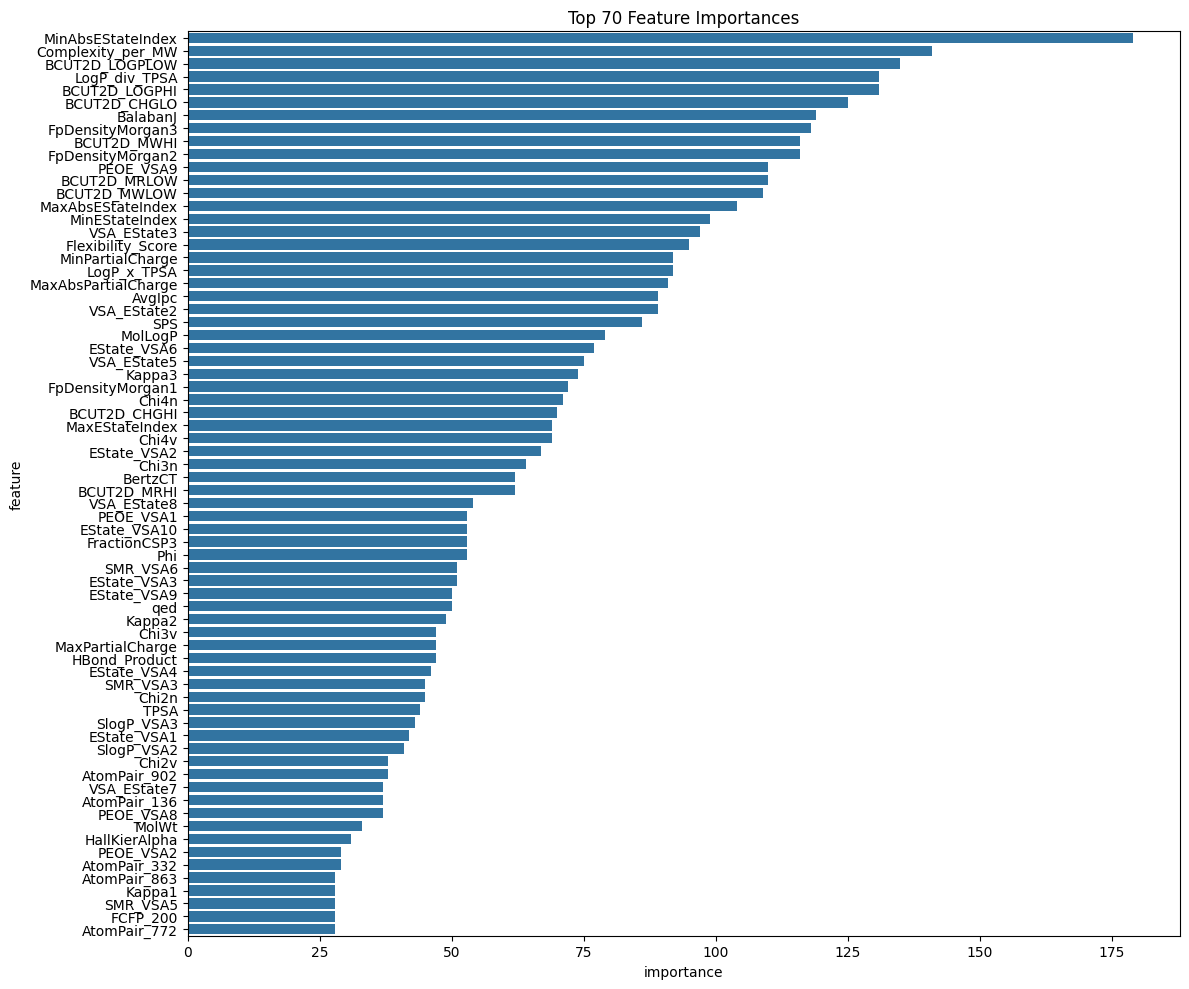

In [32]:

import matplotlib.pyplot as plt
import seaborn as sns

# Create a dataframe for feature importances
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)


# Plot the top 30 most important features
plt.figure(figsize=(12, 10))
sns.barplot(
    x='importance',
    y='feature',
    data=feature_importance_df.head(70)
)
plt.title('Top 70 Feature Importances')
plt.tight_layout()
plt.show()




In [6]:
import os
files = [f for f in os.listdir() if f.endswith('csv') and 'reprs' not in f]


In [7]:
#model.get_params()
final_params = {'boosting_type': 'gbdt',
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.03,
 'max_depth': 9,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 600,
 'num_leaves': 15,
 'objective': 'regression',
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 1.0,
 'subsample': 1.0,
 'min_data_in_leaf': 5,
 'feature_fraction': 0.4,
 'bagging_fraction': 0.8,
 'bagging_freq': 2,
 'lambda_l1': 0.9,
 'verbose': -1}

In [78]:
from collections import defaultdict

results = defaultdict(list)

for file in files:
  X_train, X_test, y_train, y_test = generate_features(file)
  final_model = lgb.LGBMRegressor(**final_params)
  final_model.fit(X_train, y_train)
  metrics = evaluate_model(final_model, X_test, y_test)

  results['file'].append(file)
  for k, v in metrics.items():
    results[k].append(v)

final_results = pd.DataFrame(results)
final_results.to_csv('final_results.csv')
final_results

merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done
MSE: 2.3519 | MAE: 1.7464 | R²: 0.7149
merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done
MSE: 2.5018 | MAE: 1.8361 | R²: 0.6774
merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done
MSE: 2.4572 | MAE: 1.8147 | R²: 0.6888
merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done
MSE: 2.5043 | MAE: 1.8148 | R²: 0.6767
merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done
MSE: 2.4540 | MAE: 1.7766 | R²: 0.6896
merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done
MSE: 2.3575 | MAE: 1.7681 | R²: 0.7135
merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done
MSE: 2.3760 | MAE: 1.7519 | R²: 0.7090
merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done
MSE: 2.5378 | MAE: 1.8475 | R²: 0.6680
merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done
MSE: 2.3815 | MAE: 1.7364 | R²: 0.7077
merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done
MSE: 2.4075 | MAE: 1.7571 | R²: 0.7012
merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done
MSE: 2.4546 | MAE: 1.8268 | R²: 0.6894
merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done
MSE: 2.4576 | MAE: 1.8232 | R²: 0.6887
merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done
MSE: 2.5019 | MAE: 1.8011 | R²: 0.6773
merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done
MSE: 2.4348 | MAE: 1.8271 | R²: 0.6944


,file,MSE,MAE,R2
0,Gd_ctopo_fp_skl_da.csv,2.351860,1.746404,0.714886
1,Gd_ctopo_fp_cmplx_da.csv,2.501752,1.836139,0.677385
2,Gd_ctopo_fp_skl_da_bonds.csv,2.457201,1.814670,0.688773
3,Gd_ctopo_fp_cmplx_da_sub.csv,2.504290,1.814788,0.676730
4,Gd_ctopo_fp_ligand.csv,2.454025,1.776614,0.689577
5,Gd_ctopo_fp_skl.csv,2.357537,1.768122,0.713508
6,Gd_ctopo_fp_cmplx.csv,2.375980,1.751892,0.709008
7,Gd_ctopo_fp_cmplx_da_sub_bonds.csv,2.537785,1.847510,0.668025
8,Gd_ctopo_fp_topo.csv,2.381503,1.736385,0.707654
9,Gd_ctopo_fp_cmplx_da_bonds.csv,2.407497,1.757091,0.701237


In [79]:
final_results['feature'] = 'full_set'

In [60]:
features = ['FCFP', 'MACCS', 'AtomPair', 'RDKIT']
cols_wo_bit = {feat: [col for col in X_train.columns.to_list() if feat in col] for feat in features}
cols_wo_bit['MolDesc'] = [name for name, func in Descriptors._descList] + ['HBond_Product', 'HBond_Sum','LogP_div_TPSA','LogP_x_TPSA','Flexibility_Score','MolWt_x_AromaticRings','Complexity_per_MW','Rigidity_Score']
bits = [col for col in X_train.columns.to_list() if 'bit' in col]

In [82]:
from collections import defaultdict

results = defaultdict(list)
models = {}

iterarion = True

for file in files:
  X_train, X_test, y_train, y_test = generate_features(file)
  if iterarion:
    for feat in cols_wo_bit:
      results['file'].append(file)
      results['feature'].append(feat)
      X_train_f = X_train[cols_wo_bit[feat]]
      X_test_f = X_test[cols_wo_bit[feat]]
      final_model = lgb.LGBMRegressor(**final_params)
      final_model.fit(X_train_f, y_train)
      metrics = evaluate_model(final_model, X_test_f, y_test)
      models[f'{feat}'] = final_model

      for k, v in metrics.items():
        results[k].append(v)
    iterarion = False

  results['file'].append(file)
  results['feature'].append('bits')
  X_train_f = X_train[bits]
  X_test_f = X_test[bits]
  final_model = lgb.LGBMRegressor(**final_params)
  final_model.fit(X_train_f, y_train)
  metrics = evaluate_model(final_model, X_test_f, y_test)
  models[f'bits_{file}'] = final_model

  for k, v in metrics.items():
    results[k].append(v)

  # cols = {feat: [col for col in X_train.columns.to_list() if feat in col] for feat in ['bit']}


final_results_f = pd.DataFrame(results)
final_results_f.to_csv('final_results_feat.csv')
final_results_f

merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done
MSE: 3.0925 | MAE: 2.4829 | R²: 0.5070
MSE: 3.0843 | MAE: 2.4663 | R²: 0.5097
MSE: 2.6911 | MAE: 2.0669 | R²: 0.6267
MSE: 3.2618 | MAE: 2.4433 | R²: 0.4516
MSE: 2.6510 | MAE: 1.8915 | R²: 0.6378
MSE: 3.9464 | MAE: 3.2198 | R²: 0.1972
merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done
MSE: 3.5778 | MAE: 2.8803 | R²: 0.3402
merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done
MSE: 3.8577 | MAE: 3.1075 | R²: 0.2329
merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done
MSE: 3.5314 | MAE: 2.7635 | R²: 0.3572
merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done
MSE: 3.6335 | MAE: 2.7944 | R²: 0.3195
merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done
MSE: 3.7624 | MAE: 3.0854 | R²: 0.2703
merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done
MSE: 3.6509 | MAE: 2.9569 | R²: 0.3129
merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done
MSE: 3.4333 | MAE: 2.6053 | R²: 0.3924
merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done
MSE: 4.2013 | MAE: 3.5146 | R²: 0.0902
merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done
MSE: 3.5151 | MAE: 2.7665 | R²: 0.3631
merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done
MSE: 4.0416 | MAE: 3.2337 | R²: 0.1580
merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done
MSE: 3.8774 | MAE: 3.0383 | R²: 0.2250
merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done
MSE: 3.9104 | MAE: 3.1898 | R²: 0.2118
merging data....
merging data - done
extracting fp....


  0%|          | 0/217 [00:00<?, ?it/s]

There are 167 MACCS Keys Features
There are 2048 RDKIT Fingerprint Features
extracting fp - done
extracting descriptors....
There Are 217 Descriptor Features
extracting descriptors - done
MSE: 3.5142 | MAE: 2.7204 | R²: 0.3634


,file,feature,MSE,MAE,R2
0,Gd_ctopo_fp_skl_da.csv,FCFP,3.092488,2.482927,0.507040
1,Gd_ctopo_fp_skl_da.csv,MACCS,3.084267,2.466292,0.509658
2,Gd_ctopo_fp_skl_da.csv,AtomPair,2.691059,2.066900,0.626714
3,Gd_ctopo_fp_skl_da.csv,RDKIT,3.261843,2.443323,0.451569
4,Gd_ctopo_fp_skl_da.csv,MolDesc,2.650957,1.891539,0.637756
5,Gd_ctopo_fp_skl_da.csv,bits,3.946362,3.219789,0.197233
6,Gd_ctopo_fp_cmplx_da.csv,bits,3.577778,2.880313,0.340185
7,Gd_ctopo_fp_skl_da_bonds.csv,bits,3.857657,3.107537,0.232916
8,Gd_ctopo_fp_cmplx_da_sub.csv,bits,3.531436,2.763495,0.357167
9,Gd_ctopo_fp_ligand.csv,bits,3.633482,2.794403,0.319479


In [88]:
template_features = ['FCFP', 'MACCS', 'AtomPair', 'RDKIT', 'MolDesc']
template_df = final_results_f[final_results_f['feature'].isin(template_features)].drop_duplicates('feature')

# Get unique files
unique_files = final_results_f['file'].unique()

# Create new rows by combining each file with each template feature
new_rows = []
for file in unique_files:
    for _, template_row in template_df.iterrows():
        new_row = template_row.copy()
        new_row['file'] = file
        new_rows.append(new_row)

# Create the new DataFrame
expanded_df = pd.DataFrame(new_rows)

# Remove duplicates in case some files already have these features
final_df = pd.concat([final_results_f, expanded_df, final_results]).drop_duplicates(subset=['file', 'feature'], keep='first').sort_values(['file','R2'], ascending=False).reset_index(drop=True)


In [89]:
final_df.head(20)

,file,feature,MSE,MAE,R2
0,Gd_ctopo_fp_topo_da.csv,full_set,2.454607,1.826760,0.689430
1,Gd_ctopo_fp_topo_da.csv,MolDesc,2.650957,1.891539,0.637756
2,Gd_ctopo_fp_topo_da.csv,AtomPair,2.691059,2.066900,0.626714
3,Gd_ctopo_fp_topo_da.csv,MACCS,3.084267,2.466292,0.509658
4,Gd_ctopo_fp_topo_da.csv,FCFP,3.092488,2.482927,0.507040
5,Gd_ctopo_fp_topo_da.csv,RDKIT,3.261843,2.443323,0.451569
6,Gd_ctopo_fp_topo_da.csv,bits,4.041646,3.233672,0.158000
7,Gd_ctopo_fp_topo.csv,full_set,2.381503,1.736385,0.707654
8,Gd_ctopo_fp_topo.csv,MolDesc,2.650957,1.891539,0.637756
9,Gd_ctopo_fp_topo.csv,AtomPair,2.691059,2.066900,0.626714


In [90]:
final_df.to_csv('result.csv')